In [9]:
#@title
from __future__ import print_function

import os
import sys
import time
import argparse
import datetime
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import re

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from matplotlib.image import imread

import fastai
from fastai.vision.data import ImageDataBunch, ImageList

from pathlib import Path
#from scipy.special import softmax
#from sklearn.model_selection import train_test_split


In [2]:
#add the  bayesiancnnn and ensai src to import path - https://stackoverflow.com/a/35273613/7154530
bcnn_module_path = os.path.abspath(os.path.join('../bayesiancnn'))
if bcnn_module_path not in sys.path:
    sys.path.append(bcnn_module_path)
    
ensai_module_path = os.path.abspath(os.path.join('../ensai'))
if ensai_module_path not in sys.path:
    sys.path.append(ensai_module_path)

In [3]:
from BBBlayers import GaussianVariationalInference
from BayesianModels.BayesianAlexNetBatchNorm import BBBAlexNetBatchNorm

In [28]:
seed = 42
net_type = 'alexnet'
dataset = 'circles'
numpix_side = 800
outputs = 1
inputs = 3
regression = True
resume = False
start_epoch = 0
n_epochs = 10 #set to 10 for MNIST, 30 for cifar10, and 200 for house pricing
lr = 1e-3
weight_decay = 1e-4
num_samples = 10
beta_type = "Blundell"
resize=800
optim_type = 'Adam'
best_acc = 0
best_loss = np.inf
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 16
# percentage of training set to use as validation
valid_size = 0.2
#load every nth saved epoch (change to a smaller number for classification problems where num_epochs is less)
load_multiple = 1 #set to 25 (or 10) for house pricing, 1 for MNIST, 3 for cifar10
classes = ['radius']
output_names = ['Radius'] #['Einstein Radius', 'Ellipticity (x)', 'Ellipticity (y)', 'Center (x)', 'Center (y)']
num_channels = 3

In [7]:
img_dir = Path('/Users/pbhambhani/misc/fl/circles/')

In [25]:
def get_label(path):
    bname = os.path.basename(str(path))
    sp = bname.split('_')
    label = float(sp[1])
    return label

In [26]:
data = (ImageList
        .from_folder(img_dir)
        .split_by_rand_pct(valid_size, seed)
        .label_from_func(get_label)
        .databunch()
        .normalize())

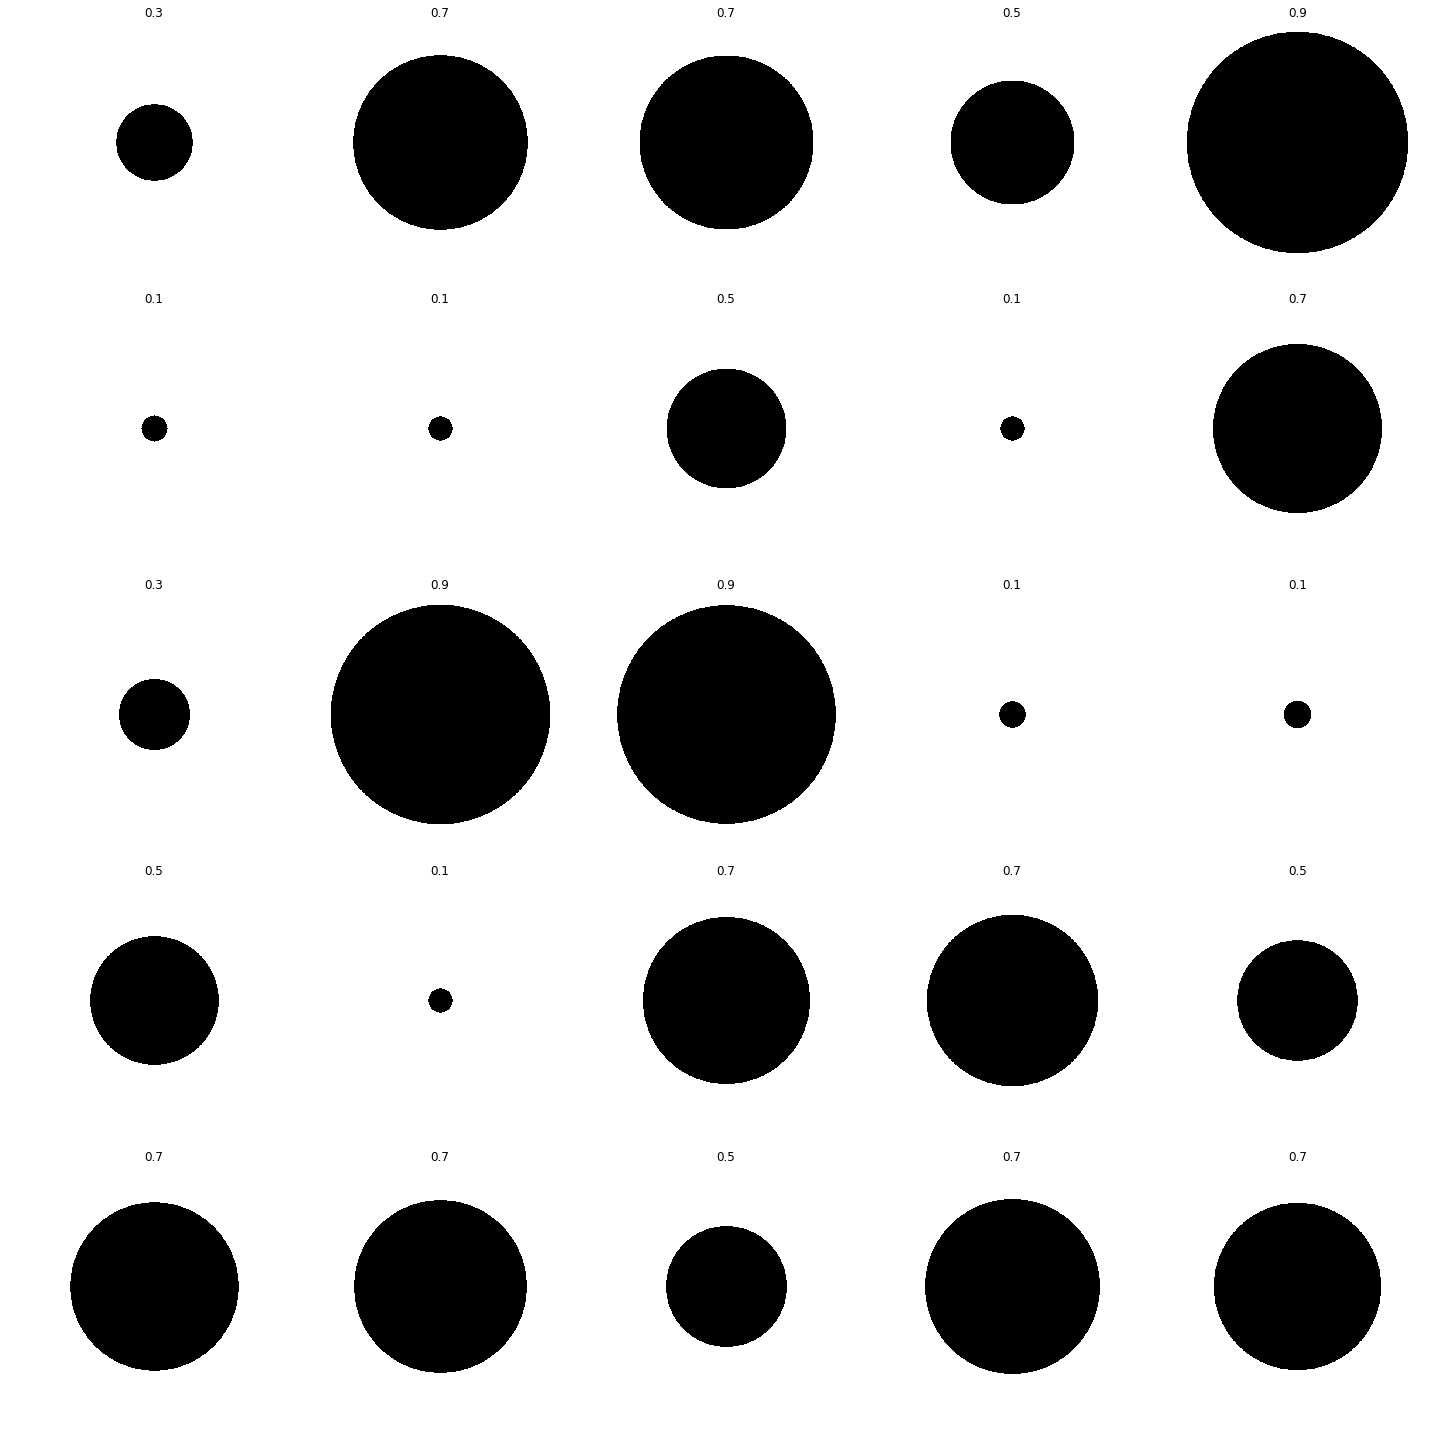

In [29]:
data.show_batch()

In [30]:
trainset = data.train_ds
testset = data.valid_ds
trainloader = data.train_dl
testloader = data.valid_dl

In [31]:
# Hyper Parameter settings
use_cuda = torch.cuda.is_available()
if use_cuda is True:
    torch.cuda.set_device(0)

In [32]:
net = BBBAlexNetBatchNorm(outputs,inputs)
if use_cuda:
    net.cuda()

loss = torch.nn.MSELoss()
vi = GaussianVariationalInference(loss, log=True)

In [33]:
#Pretty print estimates
def pp_estimates(names, confidence_mean, confidence_var, epistemic, aleatoric, tag='Parameter'):
    print('\n\n----------------------------------------------------------------------------------------------\n')
    print(    '|{:>15s}| Confidence Mean | Variance | Epistemic Uncertainty | Aleatoric Uncertainty |\n'.format(tag))
    print(    '----------------------------------------------------------------------------------------------\n')
    for i in range(len(names)):
        print('|{:>15s}|{:>17.4f}|{:>10.4f}|{:>23.4f}|{:>23.4f}|\n'.format(names[i], confidence_mean[i], confidence_var[i], epistemic[i], aleatoric[i]))
    print(    '----------------------------------------------------------------------------------------------\n\n')
    

In [34]:
def learning_rate(init, epoch):
    optim_factor = 0
    if(epoch > 40):
        optim_factor = 3
    elif(epoch > 50):
        optim_factor = 2
    elif(epoch > 60):
        optim_factor = 1

    return init*math.pow(0.2, optim_factor)

def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

In [35]:
#@title
def train(epoch, write=False):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    m = math.ceil(len(trainset) / batch_size)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate(lr, epoch), weight_decay=weight_decay)

    if write:
      print('\n=> Training Epoch #%d, LR=%.4f' %(epoch, learning_rate(lr, epoch)))
    for batch_idx, (inputs_value, targets) in enumerate(trainloader): 
        x = inputs_value.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        #x_nobias = remove_image_intensity_bias(x)
        #x = x_nobias.repeat(1, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(num_samples, 1)
        if use_cuda:
            x, y = x.cuda(), y.cuda() # GPU settings

        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        # Forward Propagation
        x, y = Variable(x), Variable(y)
        outs, kl = net.probforward(x)
        #print(inputs_value.shape, targets.shape)
        #print(x.shape, y.shape, outs.shape)
        #print(outs)
        #print(y)
        loss = vi(outs, y, kl, beta)  # Loss
        optimizer.zero_grad()
        loss.backward()  # Backward Propagation
        optimizer.step()  # Optimizer update

        train_loss += loss.data.item()
        loss = loss.data.item()
        if write:
          sys.stdout.write('\r')
          sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tIter Loss: %.4f, Cumulative Loss: %.4f' %(epoch, n_epochs-1, batch_idx+1,
                (len(trainset)//batch_size)+1, loss, train_loss))
          sys.stdout.flush()
    
    return train_loss

In [36]:
#@title 
def test(epoch, save_epoch=False):
    global best_acc, best_loss
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    predictions=[]
    means = []
    variances = []
    epistemics = []
    aleatorics = []
    m = math.ceil(len(testset) / batch_size)
    for batch_idx, (inputs_value, targets) in enumerate(testloader):
        x = inputs_value.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        #x_nobias = remove_image_intensity_bias(x)
        #x = x_nobias.repeat(1, 1, 1, 1)
        y = targets.view(-1, outputs).repeat(num_samples, 1)
        if use_cuda:
            x, y = x.cuda(), y.cuda()
        with torch.no_grad():
            x, y = Variable(x), Variable(y)
        outs, kl, mus, sigmas = net.probforward(x, ret_mean_std=True)
        #print(mns)
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0

        loss = vi(outs, y, kl, beta)

        test_loss += loss.data.item()
        loss = loss.data.item()
        preds = outs
        results = preds.cpu().detach().numpy() #.data.mean(dim=0) #torch.topk(preds.cpu().data, k=1, dim=0)
        confidence_mean = np.mean(results, axis=0)
        confidence_var = np.var(results, axis=0)
        mus = mus.cpu().detach().numpy()
        sigmas = sigmas.cpu().detach().numpy() ** 2 
        epistemic = np.mean(mus ** 2, axis=0) - np.mean(mus, axis=0) ** 2
        aleatoric = np.mean(sigmas, axis=0)
        
        means.append(confidence_mean)  
        variances.append(confidence_var)
        epistemics.append(epistemic)
        aleatorics.append(aleatoric)

    # Save checkpoint when best model
    confidence_mean = np.mean(means, axis=0)
    confidence_var = np.mean(variances, axis=0)
    epistemic = np.mean(epistemics, axis=0)
    aleatoric = np.mean(aleatorics, axis=0)
    #print(confidence_mean, confidence_var, epistemic, aleatoric)
    print('\n| Validation Epoch #%d'%(epoch))
    pp_estimates(output_names, confidence_mean, confidence_var, epistemic, aleatoric)
    state = {
        'net':net,
        'epoch':epoch,
        'loss': test_loss,
        }
    
    if save_epoch:
       if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
       
       save_point = './checkpoint/checkpoint-{}-{}-epoch-{}.pt'.format(net_type, dataset, epoch)
       torch.save(state, save_point)
       print('Saved Epoch {} as {}'.format(epoch, save_point))
      
    if test_loss < best_loss:
        print('| Saving Best model...\t\t\tLoss = %.2f' %(test_loss))
        best_loss = test_loss
        
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'+dataset+os.sep
        ckpt_name = f'model_{net_type}_{dataset}_bayesian.pt'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point+ckpt_name)
    
    return test_loss

In [37]:
def run():
  #@title
  elapsed_time = 0
  saved_epochs = []

  train_losses = []
  train_accs = []

  val_losses = []
  val_accs = []

  for epoch in range(start_epoch, start_epoch+n_epochs):
      start_time = time.time()
      nthEpoch = True #((epoch < 100) and (epoch% 10 == 0)) or ( (epoch < 1000) and (epoch%100 == 0)) or (epoch%500 == 0)
      tloss = train(epoch, nthEpoch)
      train_losses.append(tloss)
      if nthEpoch:
          vloss = test(epoch, save_epoch = True )
          val_losses.append(vloss)
          saved_epochs.append(epoch)
      
      epoch_time = time.time() - start_time
      elapsed_time += epoch_time
      if nthEpoch:
        print('| Elapsed time : %d:%02d:%02d' %(get_hms(elapsed_time)))

  print('\n Test results : Loss = %.2f' %(best_loss))
  return (saved_epochs, train_losses, val_losses)

In [38]:
(saved_epochs, train_losses, val_losses) = run()


=> Training Epoch #0, LR=0.0010


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/pbhambhani/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/pbhambhani/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/pbhambhani/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/pbhambhani/anaconda3/envs/py36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/pbhambhani/anaconda3/envs/py36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/pbhambhani/anaconda3/envs/py36/lib/python3.6/multiprocessing/con

KeyboardInterrupt: 